In [5]:
!pip install imbalanced-learn
!pip install nltk

   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/258.3 kB 1.3 MB/s eta 0:00:01
   -------------- ------------------------- 92.2/258.3 kB 1.1 MB/s eta 0:00:01
   ---------------------- ----------------- 143.4/258.3 kB 1.1 MB/s eta 0:00:01
   ------------------------------------ --- 235.5/258.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 258.3/258.3 kB 1.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Year Range Analysis:
Minimum year: 1962
Maximum year: 1970

Songs per Period:
period
Late Beatles      87
Early Beatles     50
Middle Beatles    43
Name: count, dtype: int64


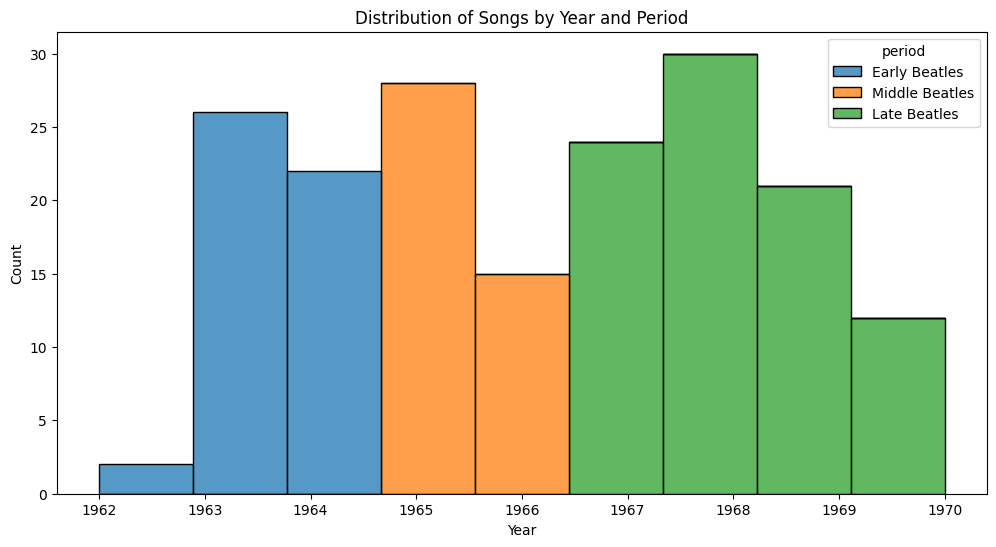

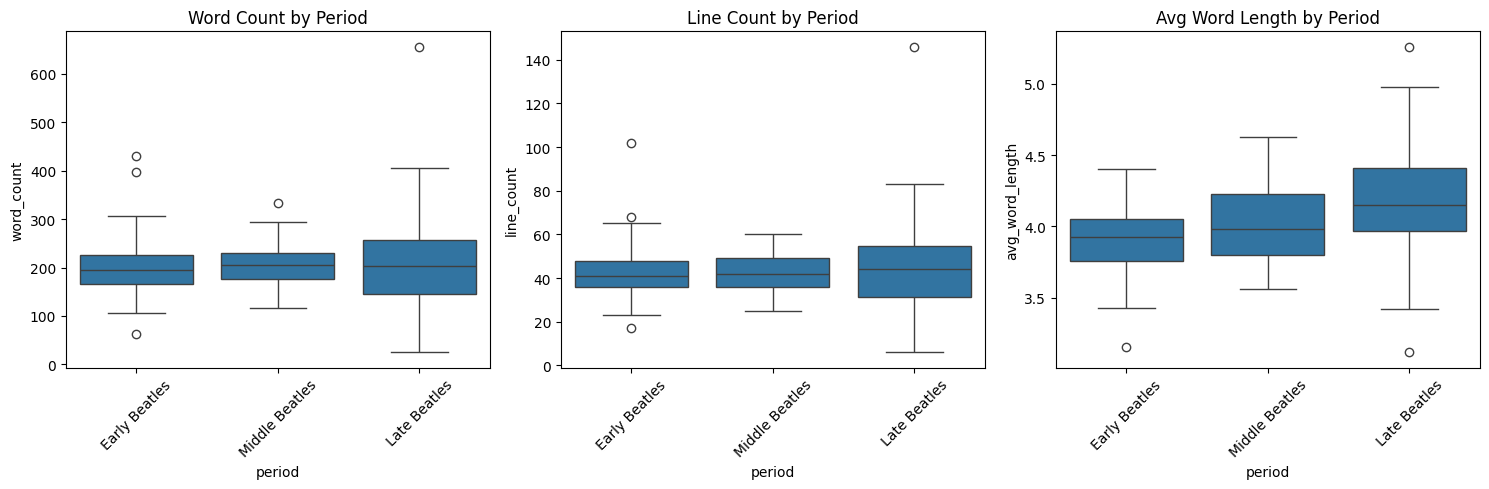


Potential outliers based on word_count:
                     title         period  word_count
166  Please Mister Postman  Early Beatles         430
28     Rock and Roll Music  Early Beatles         398
69         I Am the Walrus   Late Beatles         405
158           Revolution 9   Late Beatles         656
176       All Together Now   Late Beatles         403

Potential outliers based on line_count:
                     title         period  line_count
166  Please Mister Postman  Early Beatles         102
69         I Am the Walrus   Late Beatles          74
158           Revolution 9   Late Beatles         146
176       All Together Now   Late Beatles          83
0            Come Together   Late Beatles          78
16             Her Majesty   Late Beatles          10
59              Maggie Mae   Late Beatles           6

Potential outliers based on avg_word_length:
                                               title         period  \
170                              I Wanna Be Y

In [7]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

class DataAnalyzer:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.df = None
        
    def load_data(self):
        with open(self.file_path, 'r', encoding='utf-8') as f:
            self.data = json.load(f)
            
    def create_dataframe(self):
        # Create initial DataFrame
        self.df = pd.DataFrame([{
            'title': song['title'],
            'lyrics': song['lyrics'],
            'year': song['composition_year'],
            'period': None  # We'll set this after validation
        } for song in self.data if 'lyrics' in song and 'composition_year' in song])
        
        # Sort by year
        self.df = self.df.sort_values('year')
        
    def validate_years(self):
        """Check for songs outside our expected year range"""
        print("\nYear Range Analysis:")
        print(f"Minimum year: {self.df['year'].min()}")
        print(f"Maximum year: {self.df['year'].max()}")
        
        # Identify songs outside our periods
        outside_range = self.df[
            ~((self.df['year'].between(1962, 1964)) |  # Early
              (self.df['year'].between(1965, 1966)) |  # Middle
              (self.df['year'].between(1967, 1970)))   # Late
        ]
        
        if len(outside_range) > 0:
            print("\nSongs outside expected year range:")
            print(outside_range[['title', 'year']])
            
        return outside_range
    
    def assign_periods(self):
        """Assign periods based on validated years"""
        conditions = [
            (self.df['year'].between(1962, 1964)),
            (self.df['year'].between(1965, 1966)),
            (self.df['year'].between(1967, 1970))
        ]
        choices = ['Early Beatles', 'Middle Beatles', 'Late Beatles']
        self.df['period'] = np.select(conditions, choices, default='Unknown')
        
    def analyze_data_distribution(self):
        """Analyze the distribution of songs across periods and years"""
        # Period distribution
        print("\nSongs per Period:")
        period_dist = self.df['period'].value_counts()
        print(period_dist)
        
        # Year distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(data=self.df, x='year', hue='period', multiple="stack")
        plt.title('Distribution of Songs by Year and Period')
        plt.xlabel('Year')
        plt.ylabel('Count')
        plt.show()
        
    def analyze_lyrics_characteristics(self):
        """Analyze characteristics of lyrics across periods"""
        self.df['word_count'] = self.df['lyrics'].apply(lambda x: len(x.split()))
        self.df['line_count'] = self.df['lyrics'].apply(lambda x: len(x.split('\n')))
        self.df['avg_word_length'] = self.df['lyrics'].apply(
            lambda x: np.mean([len(word) for word in x.split()])
        )
        
        # Plot characteristics by period
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i, metric in enumerate(['word_count', 'line_count', 'avg_word_length']):
            sns.boxplot(data=self.df, x='period', y=metric, ax=axes[i])
            axes[i].set_title(f'{metric.replace("_", " ").title()} by Period')
            axes[i].tick_params(axis='x', rotation=45)
            
        plt.tight_layout()
        plt.show()
        
    def find_potential_outliers(self):
        """Identify potential outliers in lyrics characteristics"""
        metrics = ['word_count', 'line_count', 'avg_word_length']
        
        for metric in metrics:
            Q1 = self.df[metric].quantile(0.25)
            Q3 = self.df[metric].quantile(0.75)
            IQR = Q3 - Q1
            outliers = self.df[
                (self.df[metric] < (Q1 - 1.5 * IQR)) | 
                (self.df[metric] > (Q3 + 1.5 * IQR))
            ]
            
            if len(outliers) > 0:
                print(f"\nPotential outliers based on {metric}:")
                print(outliers[['title', 'period', metric]])
        
    def get_cleaned_data(self):
        """Return cleaned dataset with balanced classes if needed"""
        # Remove any rows with 'Unknown' period
        clean_df = self.df[self.df['period'] != 'Unknown'].copy()
        
        # Calculate class weights for modeling
        class_weights = dict(zip(
            clean_df['period'].unique(),
            len(clean_df) / (len(clean_df['period'].unique()) * 
                           clean_df['period'].value_counts())
        ))
        
        return clean_df, class_weights

def main():
    analyzer = DataAnalyzer("updated_beatles_songs_with_years.json")
    analyzer.load_data()
    analyzer.create_dataframe()
    
    # Validate and clean data
    outside_range = analyzer.validate_years()
    analyzer.assign_periods()
    
    # Analyze distributions
    analyzer.analyze_data_distribution()
    analyzer.analyze_lyrics_characteristics()
    analyzer.find_potential_outliers()
    
    # Get cleaned data
    clean_df, class_weights = analyzer.get_cleaned_data()
    
    print("\nClass Weights for Modeling:")
    print(class_weights)
    
    return clean_df, class_weights, analyzer

if __name__ == "__main__":
    clean_df, class_weights, analyzer = main()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dimav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dimav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\dimav\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Dataset Statistics:
--------------------------------------------------
Total number of songs: 180

Songs per period:
period
Late Beatles      87
Early Beatles     50
Middle Beatles    43
Name: count, dtype: int64



Training RandomForest...
--------------------------------------------------
Fold 1 F1-Score: 0.654
Fold 2 F1-Score: 0.439
Fold 3 F1-Score: 0.527
Fold 4 F1-Score: 0.592
Fold 5 F1-Score: 0.631

RandomForest Classification Report:
--------------------------------------------------
                precision    recall  f1-score   support

 Early Beatles       0.65      0.40      0.49        50
  Late Beatles       0.61      0.97      0.75        87
Middle Beatles       0.82      0.21      0.33        43

      accuracy                           0.63       180
     macro avg       0.69      0.52      0.52       180
  weighted avg       0.67      0.63      0.58       180


RandomForest Confusion Matrix:
--------------------------------------------------
                Early Beat

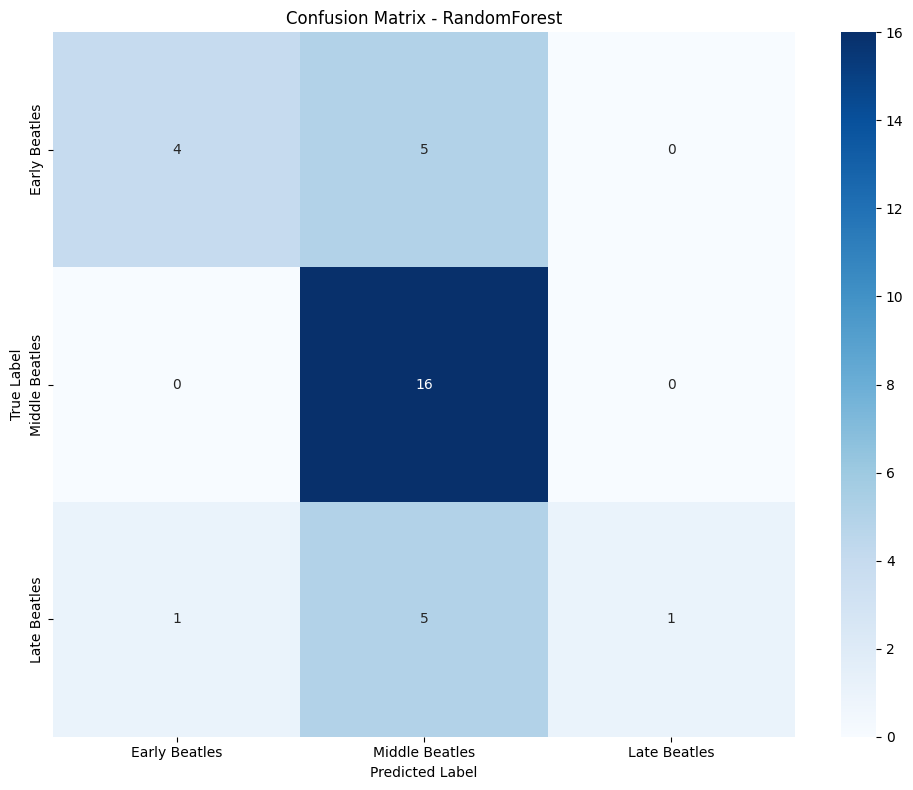


Training GradientBoosting...
--------------------------------------------------
Fold 1 F1-Score: 0.559
Fold 2 F1-Score: 0.497
Fold 3 F1-Score: 0.488
Fold 4 F1-Score: 0.601
Fold 5 F1-Score: 0.697

GradientBoosting Classification Report:
--------------------------------------------------
                precision    recall  f1-score   support

 Early Beatles       0.52      0.28      0.36        50
  Late Beatles       0.66      0.86      0.75        87
Middle Beatles       0.49      0.44      0.46        43

      accuracy                           0.60       180
     macro avg       0.55      0.53      0.52       180
  weighted avg       0.58      0.60      0.57       180


GradientBoosting Confusion Matrix:
--------------------------------------------------
                Early Beatles  Middle Beatles  Late Beatles
Early Beatles               2               4             2
Middle Beatles              1              15             1
Late Beatles                1               3     

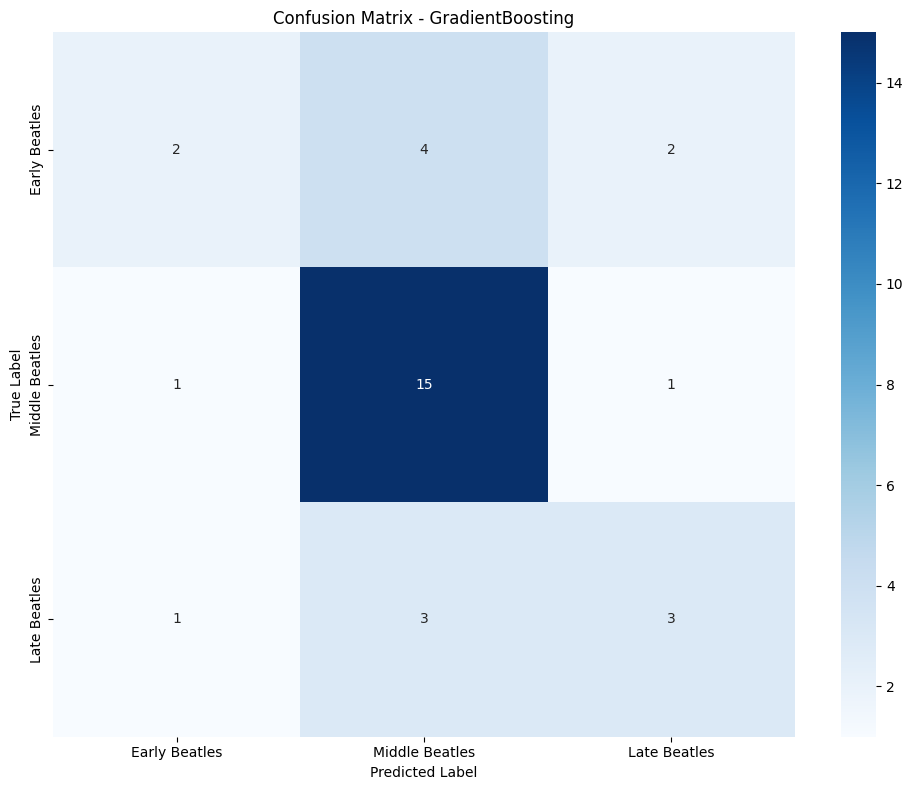


Training SVM...
--------------------------------------------------
Fold 1 F1-Score: 0.468
Fold 2 F1-Score: 0.455
Fold 3 F1-Score: 0.508
Fold 4 F1-Score: 0.535
Fold 5 F1-Score: 0.666

SVM Classification Report:
--------------------------------------------------
                precision    recall  f1-score   support

 Early Beatles       0.46      0.64      0.53        50
  Late Beatles       0.73      0.54      0.62        87
Middle Beatles       0.33      0.35      0.34        43

      accuracy                           0.52       180
     macro avg       0.51      0.51      0.50       180
  weighted avg       0.56      0.52      0.53       180


SVM Confusion Matrix:
--------------------------------------------------
                Early Beatles  Middle Beatles  Late Beatles
Early Beatles               6               1             2
Middle Beatles              4               9             4
Late Beatles                3               2             3




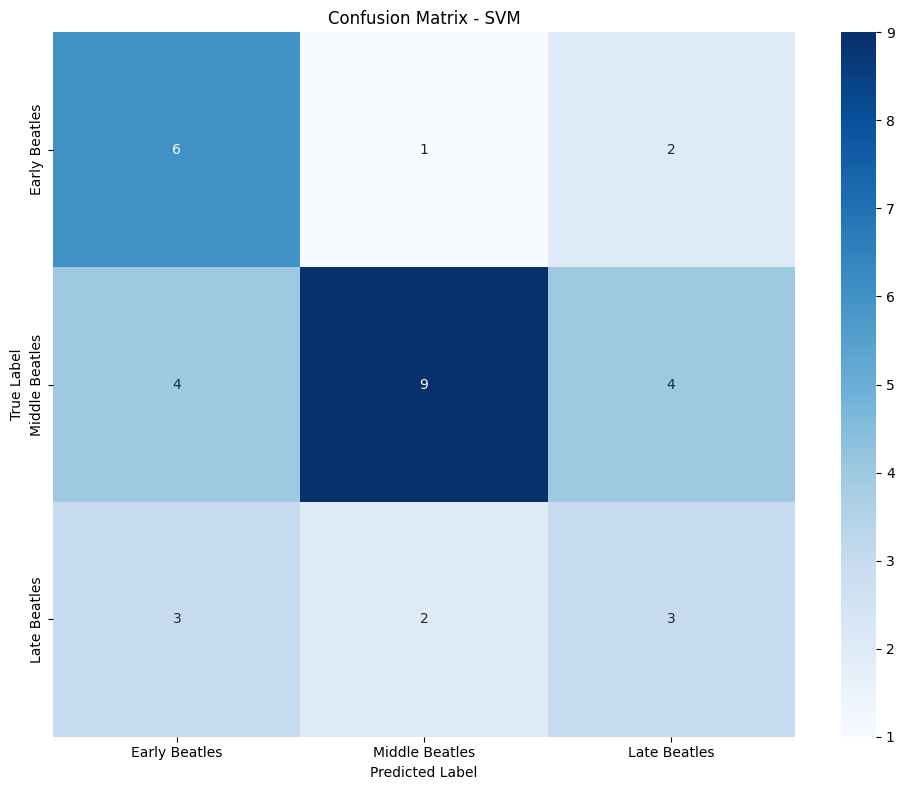


Final Results:
--------------------------------------------------
Best Classifier: RandomForest
Mean F1-Score: 0.569 (±0.078)


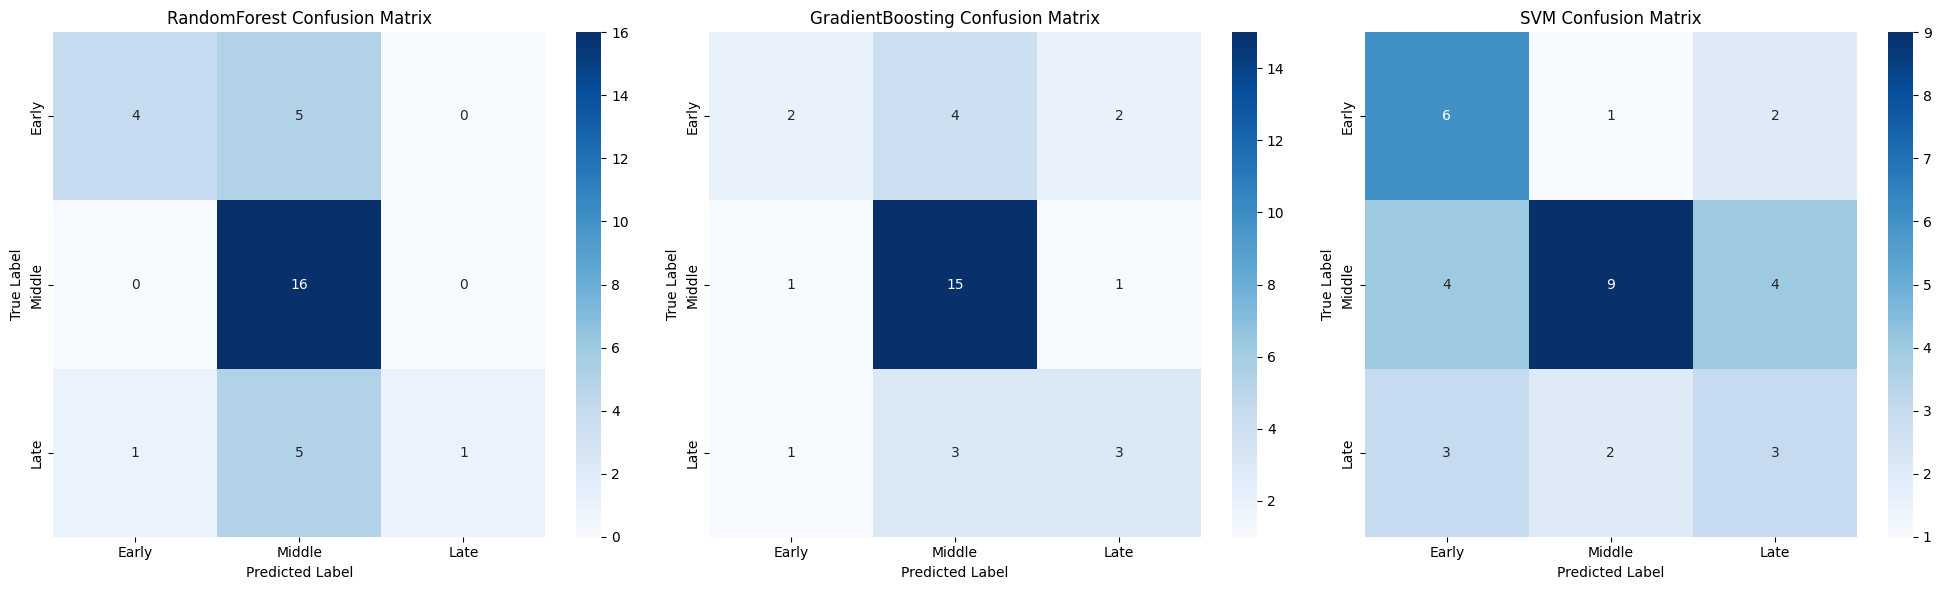

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import re
import warnings
warnings.filterwarnings('ignore')

class AdvancedFeatureExtractor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        
    def extract_musical_features(self, text):
        # Common musical terms
        musical_terms = ['verse', 'chorus', 'bridge', 'solo', 'intro', 'outro', 
                        'refrain', 'instrumental', 'harmony', 'repeat']
        
        # Count musical terms
        term_counts = sum(1 for term in musical_terms if term in text.lower())
        
        # Detect repetition patterns
        lines = text.split('\n')
        repetition_count = len(lines) - len(set(lines))
        
        return {
            'musical_term_density': term_counts / len(text.split()),
            'repetition_ratio': repetition_count / len(lines) if len(lines) > 0 else 0
        }
    
    def extract_stylistic_features(self, text):
        # Punctuation patterns
        exclamations = text.count('!')
        questions = text.count('?')
        
        # Word patterns
        words = text.split()
        avg_word_length = np.mean([len(word) for word in words]) if words else 0
        long_words = sum(1 for word in words if len(word) > 6)
        
        return {
            'exclamation_ratio': exclamations / len(words) if words else 0,
            'question_ratio': questions / len(words) if words else 0,
            'avg_word_length': avg_word_length,
            'long_word_ratio': long_words / len(words) if words else 0
        }
    
    def extract_structural_features(self, text):
        # Section analysis
        sections = re.findall(r'\[(.*?)\]', text)
        section_types = Counter(sections)
        
        # Line patterns
        lines = text.split('\n')
        empty_lines = sum(1 for line in lines if not line.strip())
        
        return {
            'section_diversity': len(section_types) / len(sections) if sections else 0,
            'verse_count': section_types.get('Verse', 0),
            'chorus_count': section_types.get('Chorus', 0),
            'bridge_count': section_types.get('Bridge', 0),
            'spacing_ratio': empty_lines / len(lines) if lines else 0
        }

class EnhancedTextProcessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.feature_extractor = AdvancedFeatureExtractor()
        
    def preprocess_text(self, text):
        # Remove section markers but keep track of them
        section_markers = re.findall(r'\[(.*?)\]', text)
        text_without_markers = re.sub(r'\[.*?\]', '', text)
        
        # Basic cleaning
        text_clean = text_without_markers.lower()
        text_clean = re.sub(r'[^a-zA-Z\s]', ' ', text_clean)
        
        # Tokenization and lemmatization
        tokens = word_tokenize(text_clean)
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens 
                 if token not in self.stop_words and len(token) > 2]
        
        return ' '.join(tokens), section_markers
    
    def extract_all_features(self, text):
        processed_text, section_markers = self.preprocess_text(text)
        
        # Combine all features
        features = {
            **self.feature_extractor.extract_musical_features(text),
            **self.feature_extractor.extract_stylistic_features(text),
            **self.feature_extractor.extract_structural_features(text)
        }
        
        return processed_text, features

class ImprovedBeatlesClassifier:
    def __init__(self, class_weights):
        self.text_processor = EnhancedTextProcessor()
        self.class_weights = class_weights
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        
        self.tfidf = TfidfVectorizer(
            max_features=2500,
            ngram_range=(1, 3),
            stop_words='english',
            max_df=0.85,
            min_df=2
        )
        
    def prepare_features(self, df):
        # Process text and extract features
        processed_data = [self.text_processor.extract_all_features(text) 
                         for text in df['lyrics']]
        
        processed_texts, feature_dicts = zip(*processed_data)
        
        # TF-IDF features
        tfidf_features = self.tfidf.fit_transform([text for text in processed_texts])
        
        # Convert feature dictionaries to DataFrame
        feature_df = pd.DataFrame(feature_dicts)
        
        # Scale features
        scaled_features = self.scaler.fit_transform(feature_df)
        
        # Combine features
        X = np.hstack([
            tfidf_features.toarray(),
            scaled_features
        ])
        
        return X
    
    def create_ensemble(self):
        base_models = [
            ('rf', RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                class_weight=self.class_weights,
                random_state=42
            )),
            ('gb', GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=5,
                random_state=42
            )),
            ('svm', SVC(
                kernel='rbf',
                class_weight=self.class_weights,
                probability=True,
                random_state=42
            ))
        ]
        
        return VotingClassifier(
            estimators=base_models,
            voting='soft'
        )
    
    def train_and_evaluate(self, df, cv_folds=5):
        X = self.prepare_features(df)
        y = self.label_encoder.fit_transform(df['period'])
        
        # Create cross-validation splits
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        # Initialize ensemble
        ensemble = self.create_ensemble()
        
        # Cross-validation
        cv_scores = []
        period_specific_scores = {period: [] for period in df['period'].unique()}
        
        for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            # Train ensemble
            ensemble.fit(X_train, y_train)
            y_pred = ensemble.predict(X_val)
            
            # Calculate metrics
            report = classification_report(y_val, y_pred, output_dict=True)
            cv_scores.append(report['weighted avg']['f1-score'])
            
            # Calculate period-specific performance
            for period in df['period'].unique():
                period_idx = self.label_encoder.transform([period])[0]
                mask = y_val == period_idx
                if np.any(mask):
                    period_score = classification_report(
                        y_val[mask], 
                        y_pred[mask], 
                        output_dict=True
                    )['weighted avg']['f1-score']
                    period_specific_scores[period].append(period_score)
            
            print(f"Fold {fold + 1} F1-Score: {cv_scores[-1]:.3f}")
        
        # Print final results
        print("\nOverall Results:")
        print(f"Mean F1-Score: {np.mean(cv_scores):.3f} (±{np.std(cv_scores):.3f})")
        
        print("\nPeriod-Specific Results:")
        for period, scores in period_specific_scores.items():
            print(f"{period}: {np.mean(scores):.3f} (±{np.std(scores):.3f})")
        
        # Train final model on full dataset
        final_model = ensemble.fit(X, y)
        
        return final_model, cv_scores

def main():
    # Load your data and class weights here
    # ... (previous data loading code) ...
    
    # Initialize and train classifier
    classifier = ImprovedBeatlesClassifier(class_weights)
    model, cv_scores = classifier.train_and_evaluate(clean_df)
    
    return model, cv_scores, classifier

if __name__ == "__main__":
    model, cv_scores, classifier = main()


Dataset Statistics:
Total number of songs: 180

Songs per period:
period
Late Beatles      87
Early Beatles     50
Middle Beatles    43
Name: count, dtype: int64

Training BERT Classifier:
-------------------------

Fold 1/5


Epoch 1/3 - Loss: 1.0989


Epoch 2/3 - Loss: 0.9984


Epoch 3/3 - Loss: 0.8945

Fold 1 Results:
Classification Report:
                precision    recall  f1-score   support

 Early Beatles       0.50      0.50      0.50        10
  Late Beatles       0.65      0.94      0.77        18
Middle Beatles       0.00      0.00      0.00         8

      accuracy                           0.61        36
     macro avg       0.38      0.48      0.42        36
  weighted avg       0.47      0.61      0.53        36



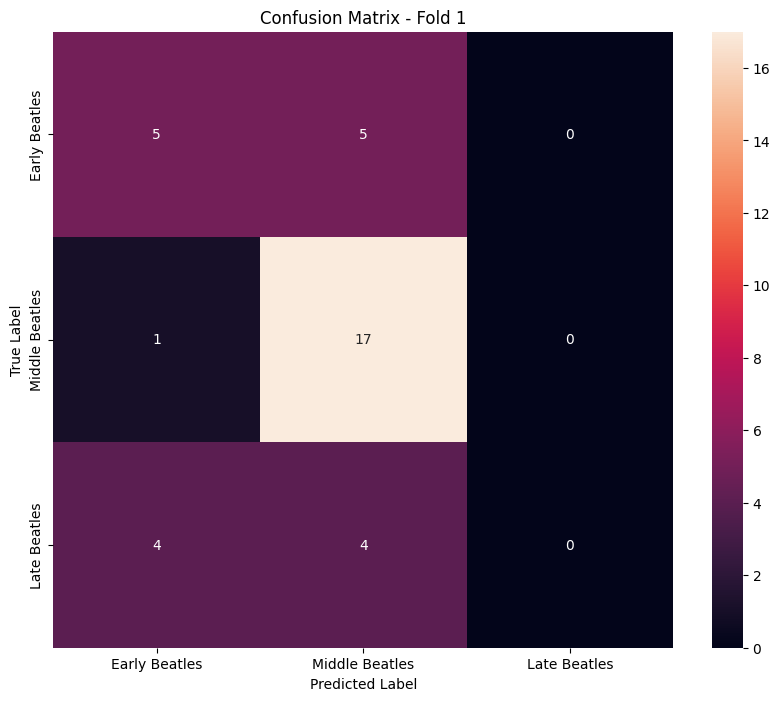


Fold 2/5


Epoch 1/3 - Loss: 0.8150


Epoch 2/3 - Loss: 0.5309


Epoch 3/3 - Loss: 0.4053

Fold 2 Results:
Classification Report:
                precision    recall  f1-score   support

 Early Beatles       0.60      0.60      0.60        10
  Late Beatles       0.82      0.78      0.80        18
Middle Beatles       0.33      0.38      0.35         8

      accuracy                           0.64        36
     macro avg       0.59      0.58      0.58        36
  weighted avg       0.65      0.64      0.65        36



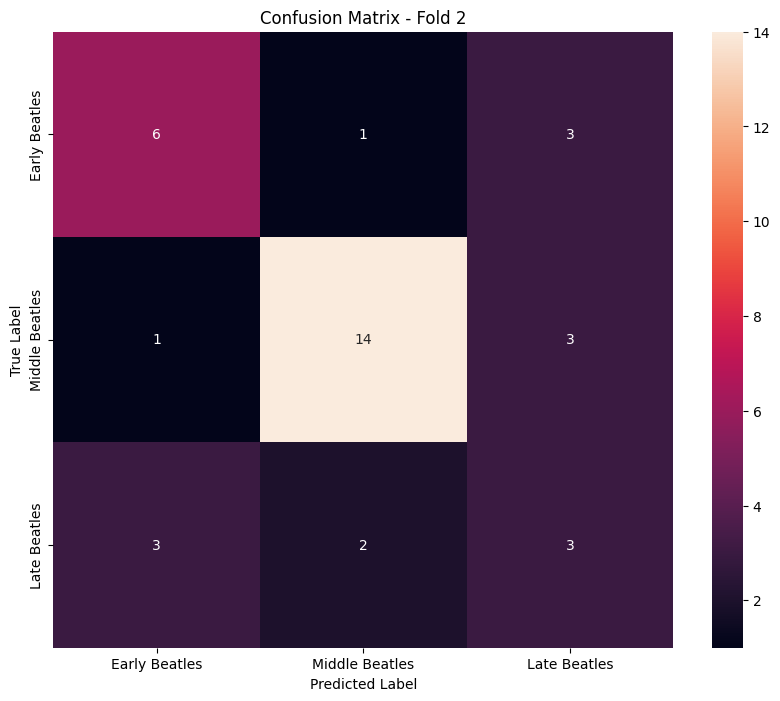


Fold 3/5


Epoch 1/3 - Loss: 0.5278


Epoch 2/3 - Loss: 0.2761


Epoch 3/3 - Loss: 0.1835

Fold 3 Results:
Classification Report:
                precision    recall  f1-score   support

 Early Beatles       0.90      0.90      0.90        10
  Late Beatles       0.89      0.94      0.91        17
Middle Beatles       1.00      0.89      0.94         9

      accuracy                           0.92        36
     macro avg       0.93      0.91      0.92        36
  weighted avg       0.92      0.92      0.92        36



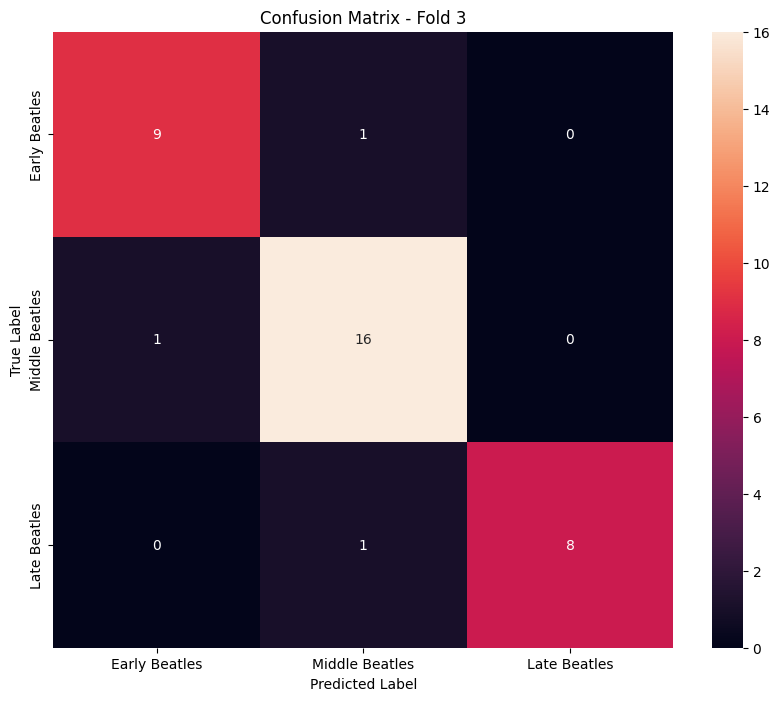


Fold 4/5


Epoch 1/3 - Loss: 0.2474


Epoch 2/3 - Loss: 0.1141


Epoch 3/3 - Loss: 0.0714

Fold 4 Results:
Classification Report:
                precision    recall  f1-score   support

 Early Beatles       0.91      1.00      0.95        10
  Late Beatles       1.00      1.00      1.00        17
Middle Beatles       1.00      0.89      0.94         9

      accuracy                           0.97        36
     macro avg       0.97      0.96      0.96        36
  weighted avg       0.97      0.97      0.97        36



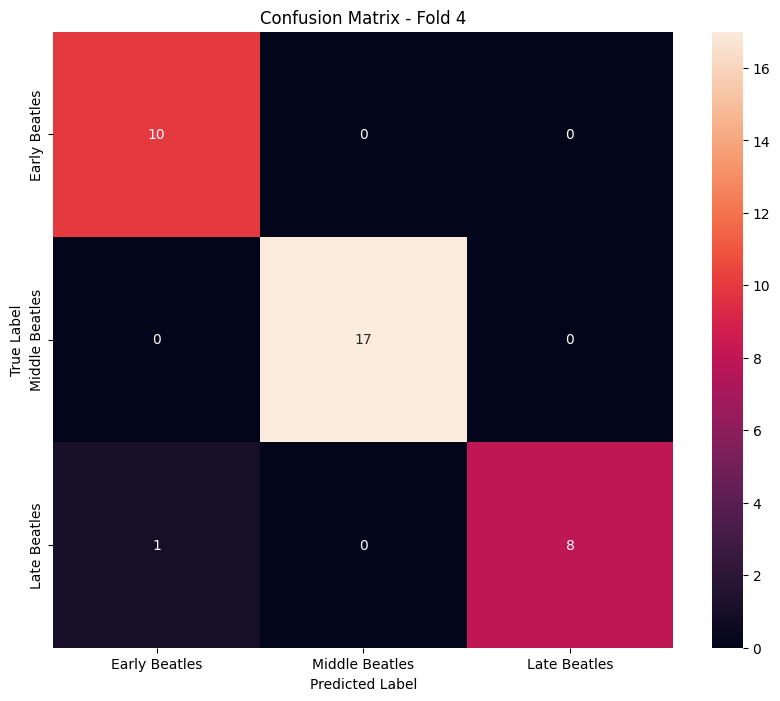


Fold 5/5


Epoch 1/3 - Loss: 0.0970


Epoch 2/3 - Loss: 0.0392


Epoch 3/3 - Loss: 0.0248

Fold 5 Results:
Classification Report:
                precision    recall  f1-score   support

 Early Beatles       1.00      1.00      1.00        10
  Late Beatles       1.00      1.00      1.00        17
Middle Beatles       1.00      1.00      1.00         9

      accuracy                           1.00        36
     macro avg       1.00      1.00      1.00        36
  weighted avg       1.00      1.00      1.00        36



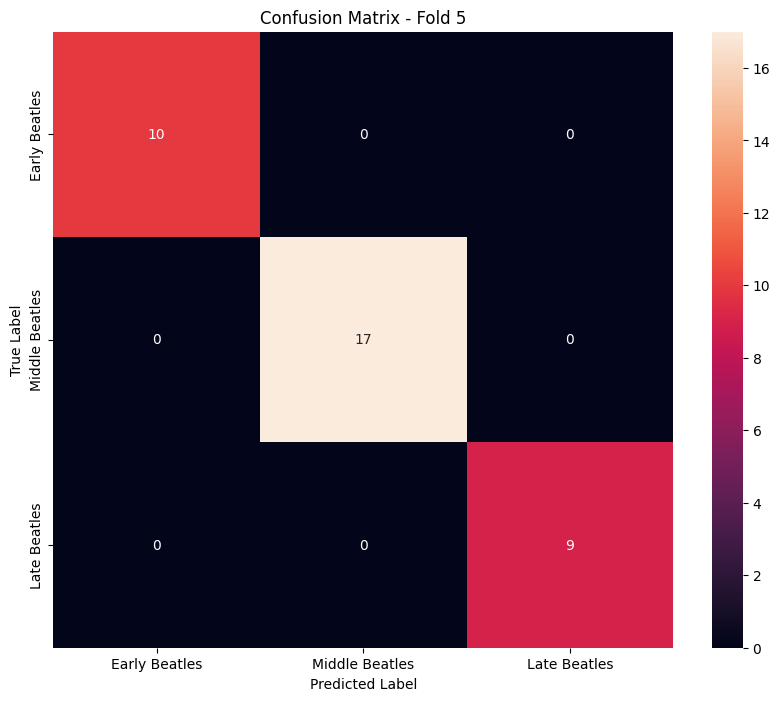


Average Performance Across All Folds:
------------------------------------

Per-Class Performance:

Early Beatles:
precision: 0.782
recall: 0.800
f1-score: 0.790

Middle Beatles:
precision: 0.667
recall: 0.631
f1-score: 0.647

Late Beatles:
precision: 0.873
recall: 0.933
f1-score: 0.897

Overall Performance:
Average Accuracy: 0.828
Average Weighted F1: 0.812


In [17]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import warnings
warnings.filterwarnings('ignore')

class BeatlesDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

class BertForBeatles(nn.Module):
    def __init__(self, bert_model, num_classes):
        super().__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs[0][:, 0, :]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits

class BERTBeatlesClassifier:
    def __init__(self, num_labels=3, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.num_labels = num_labels
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
        self.bert = AutoModel.from_pretrained('bert-base-uncased')
        self.model = BertForBeatles(self.bert, num_labels).to(device)
        
    def prepare_dataloader(self, texts, labels, batch_size=8, shuffle=True):
        dataset = BeatlesDataset(texts, labels, self.tokenizer)
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    def train_epoch(self, dataloader, optimizer, scheduler):
        self.model.train()
        total_loss = 0
        
        for batch in tqdm(dataloader, desc='Training', leave=False):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)
            
            outputs = self.model(input_ids, attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
            
        return total_loss / len(dataloader)
    
    def evaluate(self, dataloader):
        self.model.eval()
        predictions = []
        actual_labels = []
        
        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels']
                
                outputs = self.model(input_ids, attention_mask)
                _, preds = torch.max(outputs, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                actual_labels.extend(labels.numpy())
                
        return predictions, actual_labels
    
    def train_and_evaluate(self, df, cv_folds=5, epochs=3):
        label_map = {'Early Beatles': 0, 'Middle Beatles': 1, 'Late Beatles': 2}
        df['label'] = df['period'].map(label_map)
        
        skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        cv_results = []
        fold_metrics = []
        
        print("\nTraining BERT Classifier:")
        print("-------------------------")
        for fold, (train_idx, val_idx) in enumerate(skf.split(df['lyrics'], df['label']), 1):
            print(f"\nFold {fold}/{cv_folds}")
            
            train_texts = df['lyrics'].iloc[train_idx].values
            train_labels = df['label'].iloc[train_idx].values
            val_texts = df['lyrics'].iloc[val_idx].values
            val_labels = df['label'].iloc[val_idx].values
            
            train_dataloader = self.prepare_dataloader(train_texts, train_labels)
            val_dataloader = self.prepare_dataloader(val_texts, val_labels, shuffle=False)
            
            optimizer = AdamW(self.model.parameters(), lr=2e-5)
            total_steps = len(train_dataloader) * epochs
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=total_steps
            )
            
            # Train for all epochs before evaluation
            for epoch in range(epochs):
                train_loss = self.train_epoch(train_dataloader, optimizer, scheduler)
                print(f"Epoch {epoch + 1}/{epochs} - Loss: {train_loss:.4f}")
            
            # Evaluate after all epochs
            predictions, actual_labels = self.evaluate(val_dataloader)
            reverse_label_map = {v: k for k, v in label_map.items()}
            pred_labels = [reverse_label_map[p] for p in predictions]
            actual_labels = [reverse_label_map[l] for l in actual_labels]
            
            # Calculate and store metrics
            report = classification_report(actual_labels, pred_labels, output_dict=True)
            fold_metrics.append(report)
            
            print(f"\nFold {fold} Results:")
            print("Classification Report:")
            print(classification_report(actual_labels, pred_labels))
            
            # Plot confusion matrix
            cm = confusion_matrix(actual_labels, pred_labels)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', 
                      xticklabels=label_map.keys(),
                      yticklabels=label_map.keys())
            plt.title(f'Confusion Matrix - Fold {fold}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
        
        # Calculate and print average metrics
        print("\nAverage Performance Across All Folds:")
        print("------------------------------------")
        
        # Calculate averages for each class
        avg_per_class = {}
        metrics_to_avg = ['precision', 'recall', 'f1-score']
        
        for class_name in ['Early Beatles', 'Middle Beatles', 'Late Beatles']:
            avg_per_class[class_name] = {
                metric: np.mean([fold[class_name][metric] for fold in fold_metrics])
                for metric in metrics_to_avg
            }
        
        # Calculate overall averages
        avg_accuracy = np.mean([fold['accuracy'] for fold in fold_metrics])
        avg_weighted_f1 = np.mean([fold['weighted avg']['f1-score'] for fold in fold_metrics])
        
        print("\nPer-Class Performance:")
        for class_name, metrics in avg_per_class.items():
            print(f"\n{class_name}:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.3f}")
        
        print("\nOverall Performance:")
        print(f"Average Accuracy: {avg_accuracy:.3f}")
        print(f"Average Weighted F1: {avg_weighted_f1:.3f}")
        
        return fold_metrics, avg_per_class, avg_accuracy, avg_weighted_f1

def main():
    with open("updated_beatles_songs_with_years.json", "r", encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame([{
        'title': song['title'],
        'lyrics': song['lyrics'],
        'year': song['composition_year'],
        'period': 'Early Beatles' if 1962 <= song['composition_year'] <= 1964 else
                 'Middle Beatles' if 1965 <= song['composition_year'] <= 1966 else
                 'Late Beatles'
    } for song in data if 'lyrics' in song and 'composition_year' in song])
    
    print("\nDataset Statistics:")
    print(f"Total number of songs: {len(df)}")
    print("\nSongs per period:")
    print(df['period'].value_counts())
    
    classifier = BERTBeatlesClassifier()
    results = classifier.train_and_evaluate(df)
    
    return classifier, results

if __name__ == "__main__":
    classifier, results = main()

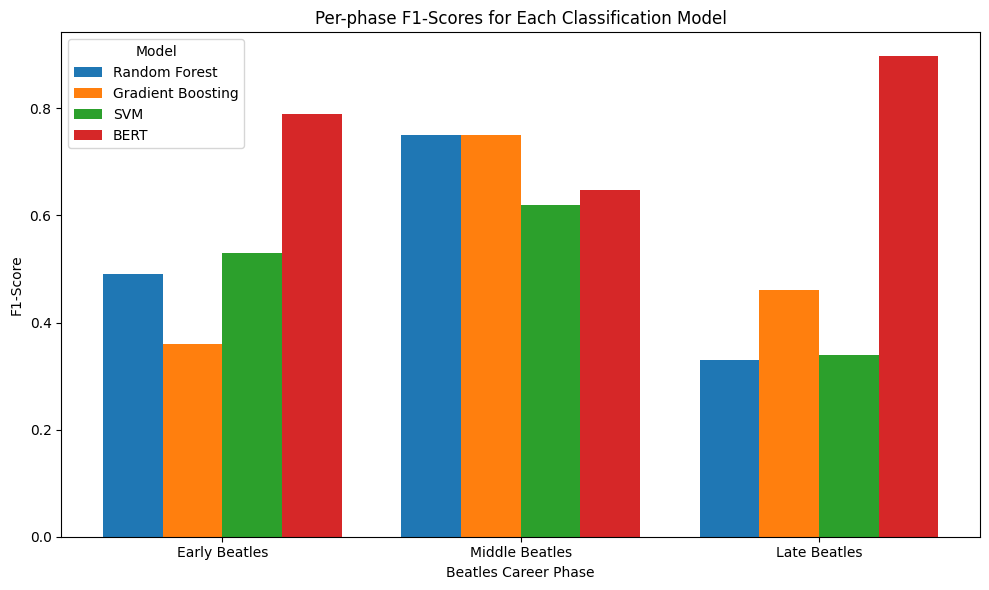

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

# Sample data representing F1-scores for each model and phase
f1_scores = {
    'Model': ['Random Forest', 'Gradient Boosting', 'SVM', 'BERT'],
    'Early Beatles': [0.49, 0.36, 0.53, 0.79],
    'Middle Beatles': [0.75, 0.75, 0.62, 0.647],
    'Late Beatles': [0.33, 0.46, 0.34, 0.897]
}

# Convert dictionary to DataFrame
df_f1_scores = pd.DataFrame(f1_scores)

# Create a bar chart to visualize F1-scores for each phase
fig, ax = plt.subplots(figsize=(10, 6))

for index, model in enumerate(df_f1_scores['Model']):
    ax.bar(
        np.arange(len(df_f1_scores.columns) - 1) + index * 0.2,  # Offset each model's bars slightly
        df_f1_scores.iloc[index, 1:],
        width=0.2,
        label=model
    )

ax.set_xlabel('Beatles Career Phase')
ax.set_ylabel('F1-Score')
ax.set_title('Per-phase F1-Scores for Each Classification Model')
ax.set_xticks(np.arange(len(df_f1_scores.columns) - 1) + 0.3)
ax.set_xticklabels(['Early Beatles', 'Middle Beatles', 'Late Beatles'])
ax.legend(title='Model')

plt.tight_layout()
plt.show()

